(1457, 48, 96)
(8760, 48, 96)
(593, 48, 96)


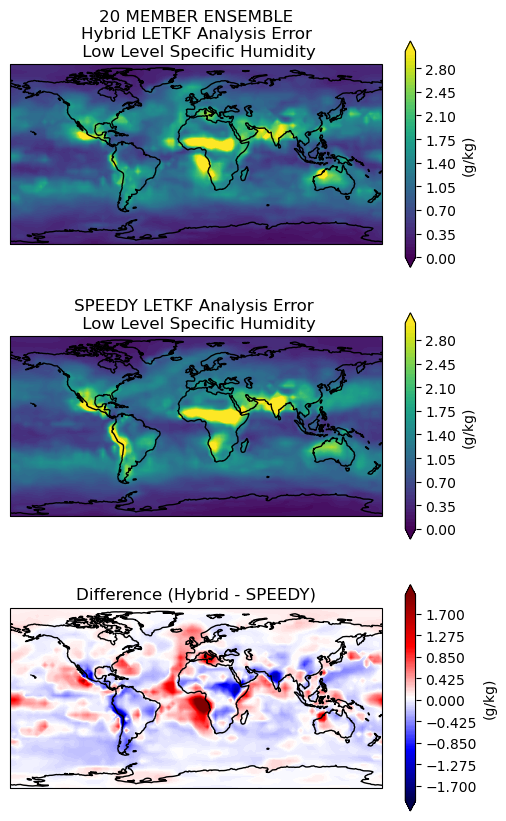

In [24]:
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import xarray as xr
import glob
from datetime import datetime, timedelta
from numba import jit

@jit()
def rms(true,prediction):
    return np.sqrt(np.nanmean((prediction-true)**2))

@jit()
def rms_tendency(variable,hours):
    variable_tendency = np.zeros((hours))
    variable = np.exp(variable) * 1000.0

    for i in range(hours):
        variable_tendency[i] = np.sqrt(np.mean((variable[i+1] - variable[i])**2.0))

    return variable_tendency

def latituded_weighted_rmse(true,prediction,lats):
    diff = prediction-true

    weights = np.cos(np.deg2rad(lats))

    weights2d = np.zeros(np.shape(diff))

    diff_squared = diff**2.0
    #weights = np.ones((10,96))

    weights2d = np.tile(weights,(96,1))
    weights2d = np.transpose(weights2d)

    masked = np.ma.MaskedArray(diff_squared, mask=np.isnan(diff_squared))
    weighted_average = np.ma.average(masked,weights=weights2d)

    return np.sqrt(weighted_average)

start_year = 2011

startdate = datetime(2011,1,1,0)
enddate = datetime(2011,12,31,0)

nature_file = f'/skydata2/troyarcomano/ERA_5/{start_year}/era_5_y{start_year}_regridded_mpi_fixed_var.nc'
analysis_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/uniform_analysis_2011_01_to_2012_05.nc'#'/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/uniform_analysis_2012_01_to_2012_09.nc'

# analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/uniform_20member_hybrid_jan1_dec31_2011.nc'
analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_uniform_Jan2011_crash_5_29.nc'
#'/skydata2/troyarcomano/letkf-hybrid-speedy/experiments/hybrid_first_test/anal_mean.nc' #'/skydata2/troyarcomano/letkf-hybrid-speedy/DATA/ensemble/anal/mean/test.nc' #'~/stable_run/rtpp_0_3.nc' #'/skydata2/troyarcomano/letkf-hybrid-speedy/DATA/ensemble/anal/mean/test.nc'
spread_file =  '/skydata2/troyarcomano/letkf-hybrid-speedy/experiments/hybrid_first_test/anal_sprd.nc' #'/skydata2/troyarcomano/letkf-hybrid-speedy/DATA/ensemble/anal/mean/test.nc' #'~/stable_run/rtpp_0_3.nc' # '/skydata2/troyarcomano/letkf-hybrid-speedy/DATA/ensemble/anal/mean/test.nc'

ds_nature = xr.open_dataset(nature_file)
ds_analysis_mean = xr.open_dataset(analysis_file)
ds_analysis_mean_speedy = xr.open_dataset(analysis_file_speedy)
ds_spread = xr.open_dataset(spread_file)

lats = ds_nature.Lat

level = 0.95 #0.2#0.95#0.51
level_era = 7 #2#7 #4

time_slice = slice(startdate,enddate)

var_era = 'Specific_Humidity'#'Temperature' #'V-wind'
var_da =  'q'#'t'#'q'
temp_500_nature = ds_nature[var_era].sel(Sigma_Level=level_era).values
temp_500_analysis = ds_analysis_mean[var_da].sel(lev=level).values
temp_500_analysis_speedy = ds_analysis_mean_speedy[var_da].sel(lev=level,time=time_slice).values
temp_500_spread = ds_spread[var_da].sel(lev=level).values

print(np.shape(temp_500_analysis_speedy))
ps_nature = ds_nature['logp'].values
ps_nature = 1000.0 * np.exp(ps_nature)
ps_analysis = ds_analysis_mean['ps'].values/100.0

xgrid = 96
ygrid = 48
length = 593#480#240  #1450 ##338 #160#64#177#1400#455

analysis_rmse = np.zeros((length))
analysis_rmse_speedy = np.zeros((length))
global_average_ensemble_spread= np.zeros((length))
ps_rmse = np.zeros((length))

analysis_error = np.zeros((length,ygrid,xgrid))
analysis_error_speedy = np.zeros((length,ygrid,xgrid))

print(np.shape(temp_500_nature))
print(np.shape(temp_500_analysis))
for i in range(length):
    analysis_rmse[i] = latituded_weighted_rmse(temp_500_nature[i*6,:,:],temp_500_analysis[i,:,:],lats)
    analysis_rmse_speedy[i] = latituded_weighted_rmse(temp_500_nature[i*6,:,:],temp_500_analysis_speedy[i,:,:],lats)
    ps_rmse[i] = rms(ps_nature[i*6,:,:],ps_analysis[i,:,:])
    analysis_error[i,:,:] = temp_500_analysis[i,:,:] - temp_500_nature[i*6,:,:]
    analysis_error_speedy[i,:,:] = temp_500_analysis_speedy[i,:,:] - temp_500_nature[i*6,:,:]
    #global_average_ensemble_spread[i] = np.average(temp_500_spread[i,:,:])

''' 24(below) instead of 28 to cut transient event (ML spin up) out in first few weeks '''
  
averaged_error = np.average(abs(analysis_error[24::,:,:]),axis=0)
averaged_error_speedy = np.average(abs(analysis_error_speedy[24::,:,:]),axis=0)

lat = ds_analysis_mean.lat.values
lon = ds_analysis_mean.lon.values

lons2d, lats2d = np.meshgrid(lon,lat)

fig = plt.figure(figsize=(6,10))
''' ax1 ===>  Makes map of hybrid letkf analysis error  '''
ax1 = plt.subplot(311,projection=ccrs.PlateCarree())
ax1.coastlines()

''' Multiply averaged_error by 1000 for spec_humid only'''

cyclic_data, cyclic_lons = add_cyclic_point(averaged_error*1000, coord=lon)
lons2d,lats2d = np.meshgrid(cyclic_lons,lat)

cf = ax1.contourf(lons2d, lats2d,cyclic_data,levels=np.arange(0,3.1,.05),extend='both')

plt.colorbar(cf,label='(g/kg)')
ax1.set_title('20 MEMBER ENSEMBLE\nHybrid LETKF Analysis Error\n Low Level Specific Humidity')

diff = averaged_error - averaged_error_speedy
cyclic_data, cyclic_lons = add_cyclic_point(diff, coord=lon)
lons2d,lats2d = np.meshgrid(cyclic_lons,lat)
'''ax2 ===>  makes plot of speedt letkf analysis error '''
ax2 = plt.subplot(312,projection=ccrs.PlateCarree())
ax2.coastlines()

cyclic_data, cyclic_lons = add_cyclic_point(averaged_error_speedy*1000, coord=lon)
lons2d,lats2d = np.meshgrid(cyclic_lons,lat)

cf = ax2.contourf(lons2d, lats2d,cyclic_data,levels=np.arange(0,3.1,.05),extend='both')
plt.colorbar(cf,label='(g/kg)')
ax2.set_title('SPEEDY LETKF Analysis Error \n Low Level Specific Humidity')
''' Times 1000 on diff for Specific Humidity to be in g/kg'''
diff = (averaged_error - averaged_error_speedy)
cyclic_data, cyclic_lons = add_cyclic_point(diff*1000, coord=lon)
lons2d,lats2d = np.meshgrid(cyclic_lons,lat)

'''ax3 ==> Makes map of difference of hybrid and speedy '''

ax3 = plt.subplot(313,projection=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_title('Difference (Hybrid - SPEEDY)')
cf = ax3.contourf(lons2d, lats2d,cyclic_data,levels=np.arange(-2,2.1,.025),extend='both',cmap='seismic')
plt.colorbar(cf,label='(g/kg)')
plt.show()

average rmse Hybrid 0.0015733272585299444
average rmse SPEEDY 0.0015347518437634666


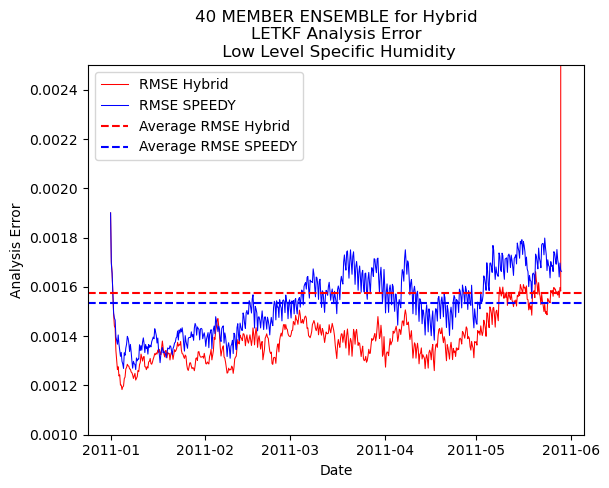

In [28]:
x = np.arange(0,length)

base = datetime(2011,1,1,0)
# plot oflonger time
date_list = [base + timedelta(days=x/4) for x in range(length)]
plt.plot(date_list,analysis_rmse,color='r',linewidth=.75,label='RMSE Hybrid ') #cov-infl1.3
plt.plot(date_list,analysis_rmse_speedy,color='b',linewidth=.75,label='RMSE SPEEDY')
plt.axhline(y=np.average(analysis_rmse[20::]), color='r', linestyle='--',label="Average RMSE Hybrid")
plt.axhline(y=np.average(analysis_rmse_speedy[20::]), color='b', linestyle='--',label="Average RMSE SPEEDY")
print('average rmse Hybrid', np.average(analysis_rmse[20::]))
print('average rmse SPEEDY', np.average(analysis_rmse_speedy[20::]))
#plt.plot(date_list,global_average_ensemble_spread,label='Ensemble Spread')
#plt.title('LETKF Analysis Error\n Low Level Specific Humidity')
plt.title('40 MEMBER ENSEMBLE for Hybrid\nLETKF Analysis Error\n Low Level Specific Humidity')
#plt.title('Ensemble Spread\nModel Level 4 Temperature')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Analysis Error')
#plt.ylabel('Analysis Error (kg/kg)')
#plt.ylabel('Ensemble Spread (K)')
# plt.xticks(date_list[::305])
# plt.xlim([datetime(2011, 1, 1,0), datetime(2011, 6, 1,0)])
plt.ylim(0.001,0.0025)

plt.show()